In [1]:
import os

import pickle
import random
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
from i1kmop9 import In1KMOPProblem, in1kmop

os.chdir('/home/wcx/gitProject/evoxbench/evoxbench_submit/c10mop8-9&i1k/i1kmop9')

Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
Auto Configuration Succeed!, Using database /home/wcx/gitProject/evoxbench/database/database.
['/home/wcx/gitProject/evoxbench/evoxbench_submit/pymoo060/', '/home/wcx/gitProject/evoxbench/evoxbench_submit/', '/sdb_new/gitProject/evoxbench/evoxbench_submit/c10mop8-9&i1k/i1kmop9', '/home/wcx/anaconda3/envs/evoxbench/lib/python38.zip', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/lib-dynload', '', '/home/wcx/.local/lib/python3.8/site-packages', '/home/wcx/anaconda3/envs/evoxbench/lib/python3.8/site-packages', '/home/wcx/gitProject/evoxbench/database/database', '/home/wcx/gitProject/evoxbench/database/database']


In [2]:
args = edict()
args.run = 1
args.seed = args.run
args.pid = 9

In [3]:
# set seed
random.seed(args.seed)
np.random.seed(args.seed)

In [4]:
benchmark = in1kmop(args.pid)
problem = In1KMOPProblem(benchmark, args.pid)

# Sample and divide the dataset

In [5]:
d = './'
obj_d = d + '1kl_train_data_10000_{:02d}.pkl'.format(args.run)
search_space = benchmark.search_space
evaluator = benchmark.evaluator
if not os.path.exists(obj_d):
    
    X = np.array([search_space._sample(phenotype=False) for _ in range(10000)])
    X = X[problem._get_fine_x(X)]
    
    archs = search_space.decode(X)
    evaluator.evaluate(archs)
    y = evaluator.evaluate(archs, true_eval=True)
    pickle.dump((X, y), open(obj_d, 'wb')) 
    whole_X, whole_y = X.copy(), y.copy()
else:
    X, y = pickle.load(open(obj_d, 'rb'))
    whole_X, whole_y = X.copy(), y.copy()

In [6]:
print(len(X))

10000


<AxesSubplot: ylabel='Count'>

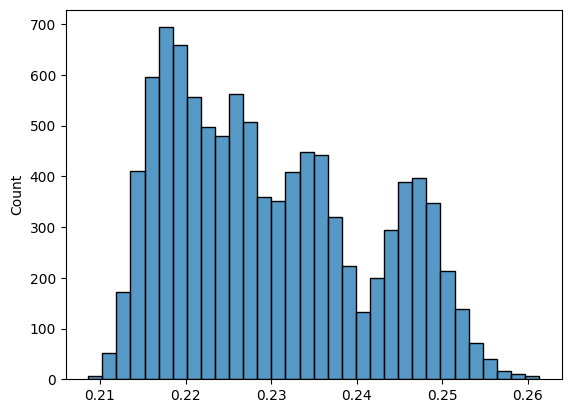

In [7]:
import seaborn as sns
sns.histplot([i['err'] for i in y])

In [8]:
X.shape

(10000, 21)

In [9]:
y

[OrderedDict([('err', 0.2367952735334946),
              ('params', 6757176),
              ('flops', 632096992),
              ('latency', 29.286491968337177)]),
 OrderedDict([('err', 0.24911226752054383),
              ('params', 6957592),
              ('flops', 522610080),
              ('latency', 26.206915245627943)]),
 OrderedDict([('err', 0.21391453903695434),
              ('params', 8409088),
              ('flops', 1147568576),
              ('latency', 55.48639088101861)]),
 OrderedDict([('err', 0.22071247355613177),
              ('params', 7500400),
              ('flops', 942447856),
              ('latency', 47.317013508885005)]),
 OrderedDict([('err', 0.21360112816311805),
              ('params', 8528600),
              ('flops', 1155026096),
              ('latency', 55.266420164296676)]),
 OrderedDict([('err', 0.21644129851398342),
              ('params', 8699096),
              ('flops', 1120757696),
              ('latency', 55.93038872959712)]),
 OrderedDict([('

# Train the accuracy model

In [10]:
def aux_err(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_absolute_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [11]:
train_len = 2000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['err'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['err'] for i in test_y])
err_models, mae_errs = aux_err(trn_x, trn_y)

train data shape:  (2000, 21) 
test data shape:  (8000, 21)
0:	learn: 0.0107617	test: 0.0099922	best: 0.0099922 (0)	total: 49.7ms	remaining: 8m 17s
500:	learn: 0.0001141	test: 0.0007154	best: 0.0007154 (500)	total: 481ms	remaining: 9.12s
1000:	learn: 0.0000238	test: 0.0007004	best: 0.0007004 (1000)	total: 890ms	remaining: 8s
1500:	learn: 0.0000056	test: 0.0006990	best: 0.0006990 (1496)	total: 1.3s	remaining: 7.38s
2000:	learn: 0.0000015	test: 0.0006988	best: 0.0006988 (1984)	total: 1.71s	remaining: 6.84s
2500:	learn: 0.0000004	test: 0.0006988	best: 0.0006988 (2437)	total: 2.13s	remaining: 6.39s
3000:	learn: 0.0000001	test: 0.0006988	best: 0.0006988 (2794)	total: 2.55s	remaining: 5.94s
3500:	learn: 0.0000000	test: 0.0006988	best: 0.0006988 (3343)	total: 2.96s	remaining: 5.5s
4000:	learn: 0.0000000	test: 0.0006988	best: 0.0006988 (3343)	total: 3.37s	remaining: 5.06s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.0006987956124
bestIteration = 3343

Shrink model to f

In [12]:
mae_errs

[0.00046282975846105606,
 0.00048381070122785924,
 0.0005020669391761056,
 0.0005252163324251564,
 0.00044277309240311655]

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in err_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  4.0171943300175885e-07 
mae_err:  0.00043463767517960995


(0.0, 35.0)

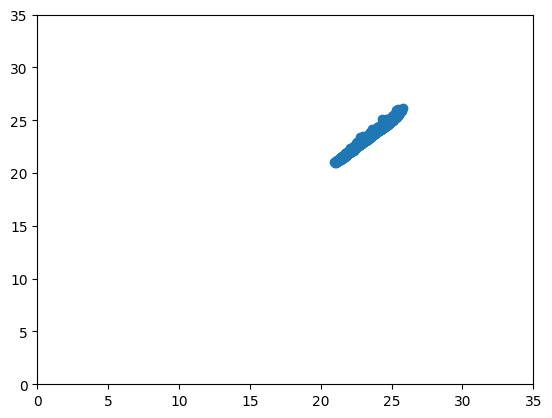

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

comp = pd.DataFrame({'pred': pred_y, 'true': tst_y})
plt.scatter(comp['pred']*100, comp['true']*100)
plt.xlim(0, 35)
plt.ylim(0, 35)

In [15]:
def get_pred_err(X):
    pred_y_list = []
    for model in err_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)

In [16]:
get_pred_err(test_x[:10])

array([0.223655  , 0.22344554, 0.2473359 , 0.21576536, 0.24229043,
       0.24873367, 0.23494981, 0.21582415, 0.23813982, 0.22564849])

In [23]:
# it is also feasible to dump a model per run 
import pickle
d = './'
with open(d + 'err_models_2000.pkl', 'wb') as f:
    pickle.dump(err_models, f)

# Train the latency model

In [17]:
def aux_lat(train_x, train_y):
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from catboost import CatBoostRegressor, Pool
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=args.seed)

    models, errs = [], []
    X, y = train_x, train_y
    for train_idx, test_idx in kfold.split(X, y):
        model = CatBoostRegressor(iterations=10000, learning_rate=0.1, depth=6, random_seed=args.seed,
                                loss_function='RMSE', verbose=True, early_stopping_rounds=1000)
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        model.fit(X_train, y_train, eval_set=Pool(X_test, y_test), use_best_model=True, verbose=500)
        
        y_pred = model.predict(X_test)
        models.append(model)
        
        err = mean_absolute_error(y_test, y_pred)
        errs.append(err)

    return models, errs

In [18]:
train_len = 2000
train_x, train_y = X[:train_len], y[:train_len]
test_x, test_y = X[train_len:], y[train_len:]
print('train data shape: ', train_x.shape, '\ntest data shape: ', test_x.shape)

trn_x = train_x
trn_y = np.array([i['latency'] for i in train_y])
tst_x = test_x
tst_y = np.array([i['latency'] for i in test_y])
lat_models, mae_errs = aux_lat(trn_x, trn_y)

train data shape:  (2000, 21) 
test data shape:  (8000, 21)
0:	learn: 9.0137313	test: 8.9315774	best: 8.9315774 (0)	total: 1.44ms	remaining: 14.4s
500:	learn: 0.1596784	test: 1.1294499	best: 1.1294499 (500)	total: 420ms	remaining: 7.95s
1000:	learn: 0.0327508	test: 1.1023508	best: 1.1023492 (997)	total: 825ms	remaining: 7.41s
1500:	learn: 0.0079195	test: 1.0994538	best: 1.0994509 (1498)	total: 1.25s	remaining: 7.08s
2000:	learn: 0.0019871	test: 1.0992345	best: 1.0992329 (1943)	total: 1.66s	remaining: 6.65s
2500:	learn: 0.0005349	test: 1.0991605	best: 1.0991600 (2491)	total: 2.09s	remaining: 6.26s
3000:	learn: 0.0001514	test: 1.0991501	best: 1.0991496 (2955)	total: 2.5s	remaining: 5.83s
3500:	learn: 0.0000437	test: 1.0991457	best: 1.0991455 (3494)	total: 2.92s	remaining: 5.42s
4000:	learn: 0.0000127	test: 1.0991440	best: 1.0991440 (3991)	total: 3.34s	remaining: 5.01s
4500:	learn: 0.0000037	test: 1.0991436	best: 1.0991436 (4455)	total: 3.76s	remaining: 4.6s
5000:	learn: 0.0000011	test: 1

In [19]:
# Validate on the test set and plot correlation figures
from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_y_list = []
for model in lat_models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y)
pred_y = np.array(pred_y_list).mean(axis=0)
mse_err = mean_squared_error(tst_y, pred_y)
mae_err = mean_absolute_error(tst_y, pred_y)
print('mse_err: ', mse_err, '\nmae_err: ', mae_err)

mse_err:  0.7728644910045603 
mae_err:  0.6257527139422607


In [20]:
def get_pred_lat(X):
    pred_y_list = []
    for model in lat_models:
        pred_y = model.predict(X)
        pred_y_list.append(pred_y)
    return np.array(pred_y_list).mean(axis=0)
get_pred_lat(test_x[:10])

array([40.83322861, 51.65949152, 25.47813076, 51.65895812, 35.20581916,
       25.10838339, 31.72658825, 53.43283946, 30.02129703, 39.79941764])

In [21]:
# it is also feasible to dump a model per run 
import pickle
d = './'
with open(d + 'lat_models_2000.pkl', 'wb') as f:
    pickle.dump(lat_models, f)